In [5]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 1 Install Libraries

In [3]:
pip install pykalman

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.1/252.1 kB 6.6 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.8/159.8 kB 8.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


# 2 Import Libraries

In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import yfinance as yf

from statsmodels.tsa.stattools import coint
from pykalman import KalmanFilter

# 3 Download German Stock Data

In [7]:
tickers = ["SAP.DE", "SIE.DE"]

data = yf.download(tickers, start="2015-01-01", end="2026-01-01")["Close"]

data = data.dropna()

data.head()

/tmp/ipykernel_55/3568128456.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2015-01-01", end="2026-01-01")["Close"]
[*********************100%***********************]  2 of 2 completed


Ticker,SAP.DE,SIE.DE
Date,,
2015-01-02,49.115639,57.480671
2015-01-05,47.496998,55.745712
2015-01-06,46.426334,55.696659
2015-01-07,46.257725,56.052242
2015-01-08,47.269375,57.885300


# 4 Plot Price Series

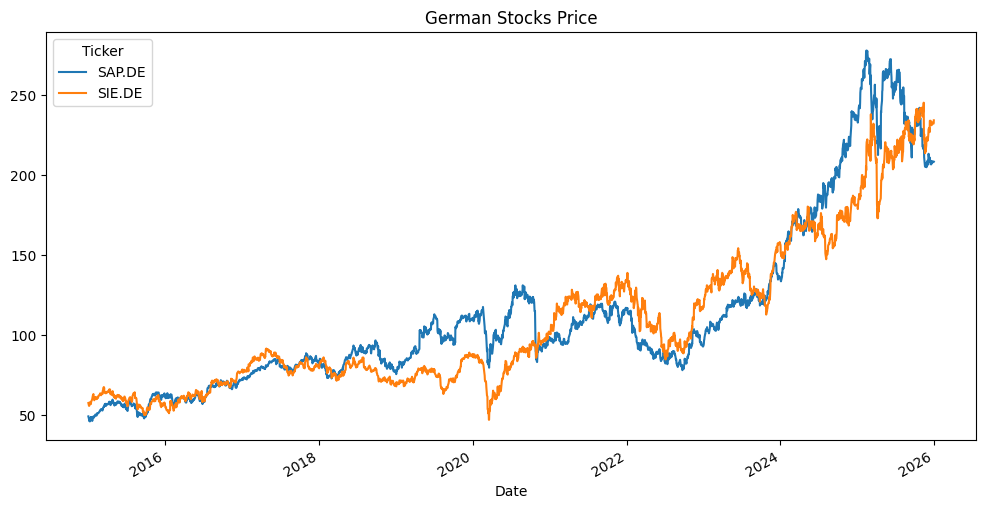

In [8]:
data.plot(figsize=(12,6), title="German Stocks Price")
plt.show()

# 5 Cointegration Test

In [9]:
score, pvalue, _ = coint(data["SAP.DE"], data["SIE.DE"])

print("Cointegration p-value:", pvalue)

Cointegration p-value: 0.4484829422575766


if

In [10]:
pvalue < 0.05

np.False_

Pairs trading is valid.

# 6 Kalman Filter Dynamic Hedge Ratio

In [11]:
def kalman_filter(y, x):

    delta = 1e-5
    trans_cov = delta / (1 - delta) * np.eye(2)

    obs_mat = np.vstack([x, np.ones(len(x))]).T[:, np.newaxis]

    kf = KalmanFilter(
        n_dim_obs=1,
        n_dim_state=2,
        initial_state_mean=np.zeros(2),
        initial_state_covariance=np.ones((2,2)),
        transition_matrices=np.eye(2),
        observation_matrices=obs_mat,
        observation_covariance=1.0,
        transition_covariance=trans_cov
    )

    state_means, state_covs = kf.filter(y.values)

    return state_means

# 7 Estimate Dynamic Beta

In [12]:
state_means = kalman_filter(data["SAP.DE"], data["SIE.DE"])

beta = state_means[:,0]
intercept = state_means[:,1]

data["beta"] = beta

# 8 Construct Dynamic Spread

In [13]:
data["spread"] = data["SAP.DE"] - data["beta"] * data["SIE.DE"]

# 9 Plot Spread

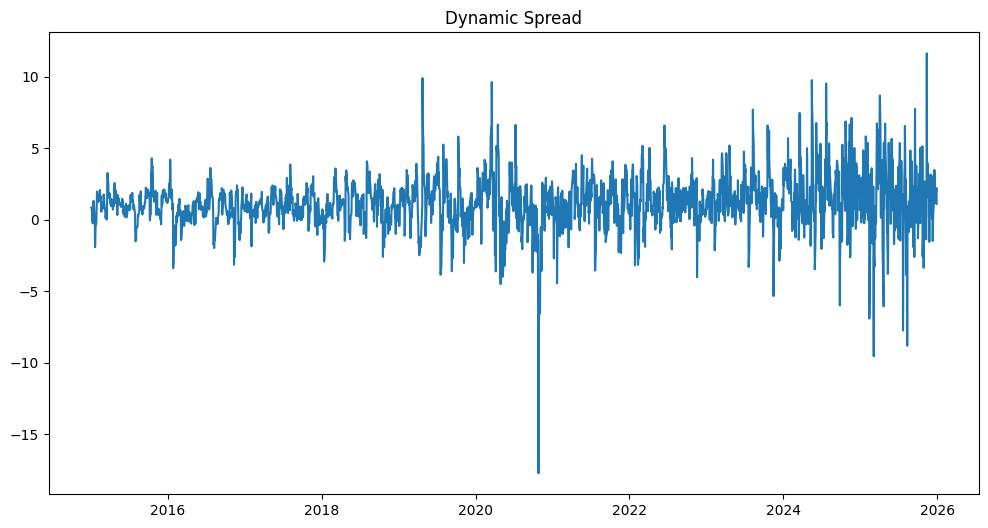

In [14]:
plt.figure(figsize=(12,6))
plt.plot(data["spread"])
plt.title("Dynamic Spread")
plt.show()

# 10 Calculate Z-Score

In [15]:
window = 30

data["mean"] = data["spread"].rolling(window).mean()
data["std"] = data["spread"].rolling(window).std()

data["zscore"] = (data["spread"] - data["mean"]) / data["std"]

# 11 Trading Signals

In [16]:
entry = 2
exit = 0.5

data["long"] = data["zscore"] < -entry
data["short"] = data["zscore"] > entry

data["exit"] = abs(data["zscore"]) < exit

# 12 Position Logic

In [17]:
position = 0
positions = []

for i in range(len(data)):

    if position == 0:

        if data["long"].iloc[i]:
            position = 1

        elif data["short"].iloc[i]:
            position = -1

    elif position == 1 and data["exit"].iloc[i]:

        position = 0

    elif position == -1 and data["exit"].iloc[i]:

        position = 0

    positions.append(position)

data["position"] = positions

# 13 Strategy Returns

In [18]:
data["SAP_ret"] = data["SAP.DE"].pct_change()
data["SIE_ret"] = data["SIE.DE"].pct_change()

data["strategy"] = data["position"].shift(1) * (
    data["SAP_ret"] - data["beta"] * data["SIE_ret"])

# 14 Equity Curve

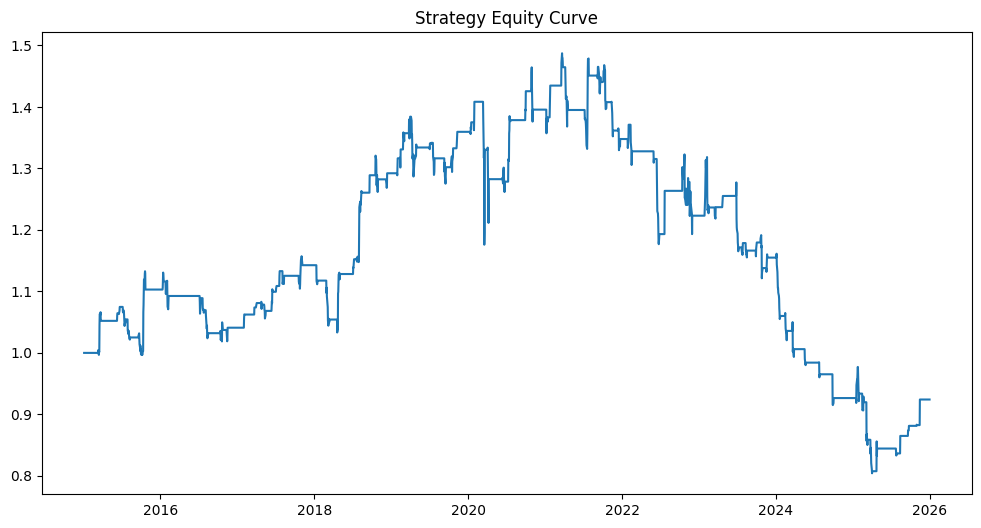

In [19]:
data["equity"] = (1 + data["strategy"]).cumprod()

plt.figure(figsize=(12,6))
plt.plot(data["equity"])
plt.title("Strategy Equity Curve")
plt.show()

# 15 Performance Metrics

In [20]:
sharpe = np.sqrt(252) * data["strategy"].mean() / data["strategy"].std()

print("Sharpe Ratio:", sharpe)

print("Total Return:", data["equity"].iloc[-1] - 1)

Sharpe Ratio: -0.00044712631762955856
Total Return: -0.07583595249516661
